# Optiver - Trading at the Close

https://www.kaggle.com/competitions/optiver-trading-at-the-close/overview

- Build data loading and preprocessing with Tensorflow. Since we are using Kaggle's training data, you will have to split their training data into our training set and test set to build and evaluate your model. Their test data doesn't have label, so we won't use it for evaluation but only use it to submit your prediction to Kaggle. (2pts)
- Implement one or more deep learning models. You can choose any deep learning models. (3pts)
- Train your models and modify your models. You will need to show your improvements on your model, such as adding more layers, adding more neurons, using different models, changing batch size, adding normalization, etc. (3pts)
- Evaluate your models to show the accuracy. (2pts)

## Team

1. Jyothsna Kaamala - jk734
2. Himasundhar Raju Meesala - hm496

In [1]:
!nvidia-smi

Wed Dec 20 20:25:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import plot_model

In [4]:
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None

In [5]:
import tensorflow as tf
len(tf.config.experimental.list_physical_devices('GPU'))

1

## Load the data

In [6]:
df = pd.read_csv("/train.csv")
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [7]:
df.shape

(5237980, 17)

The dataset is very huge, so taking a sample of the dataset because of the memory issues.

In [8]:
df = df.sample(frac=0.5, random_state=42)  # random_state ensures reproducibility
df = df.reset_index(drop=True)

## EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2618990 entries, 0 to 2618989
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 339.7+ MB


In [10]:
desc = pd.DataFrame(index = list(df))
desc['count'] = df.count()
desc['nunique'] = df.nunique()
desc['%unique'] = desc['nunique'] / len(df) * 100
desc['type'] = df.dtypes
desc = pd.concat([desc, df.describe()], axis = 1)

desc

,count,nunique,%unique,type,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
stock_id,2618990.0,200.0,0.007637,int64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_id,2618990.0,481.0,0.018366,int64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seconds_in_bucket,2618990.0,55.0,0.002100,int64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imbalance_size,2618887.0,1678801.0,64.101085,float64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imbalance_buy_sell_flag,2618990.0,3.0,0.000115,int64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reference_price,2618887.0,25936.0,0.990305,float64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matched_size,2618887.0,1778934.0,67.924429,float64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
far_price,1172101.0,83262.0,3.179164,float64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
near_price,1190629.0,72504.0,2.768395,float64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bid_price,2618887.0,25643.0,0.979118,float64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 103
imbalance_buy_sell_flag          0
reference_price                103
matched_size                   103
far_price                  1446889
near_price                 1428361
bid_price                      103
bid_size                         0
ask_price                      103
ask_size                         0
wap                            103
target                          43
time_id                          0
row_id                           0
dtype: int64

In [12]:
num_vars = ['date_id', 'seconds_in_bucket', 'imbalance_size',
            'reference_price', 'matched_size', 'far_price',
            'near_price', 'bid_price', 'bid_size', 'ask_price',
            'ask_size', 'wap']

cat_vars = ['stock_id', 'imbalance_buy_sell_flag', 'time_id']

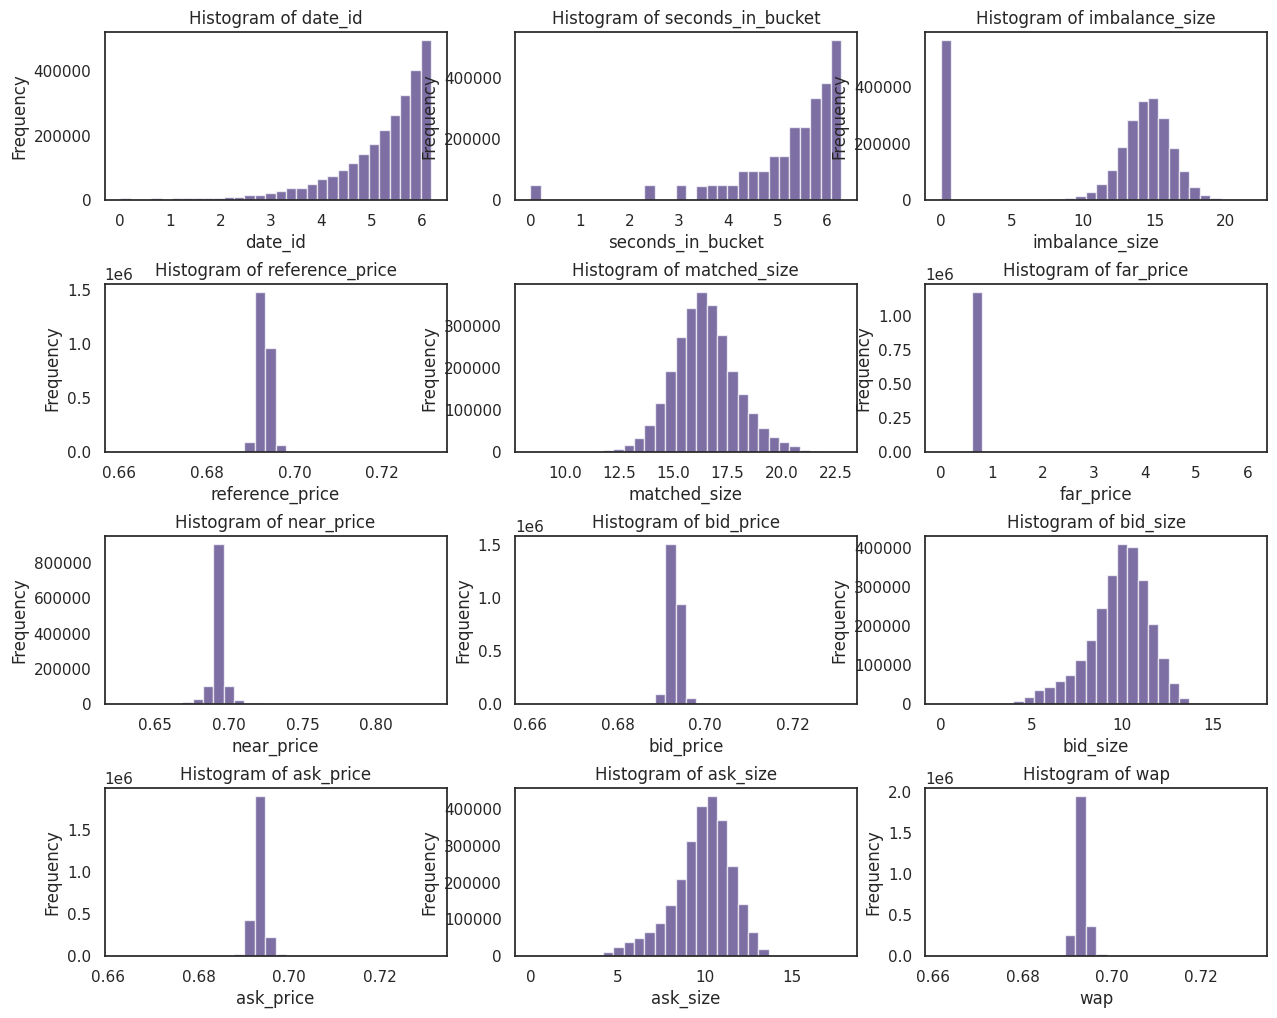

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)
axes = axes.ravel()  # Flattening the array of axes

for i, col in enumerate(num_vars):
    axes[i].hist(np.log1p(df[col]), bins=30, color=pal[0], alpha=0.7)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


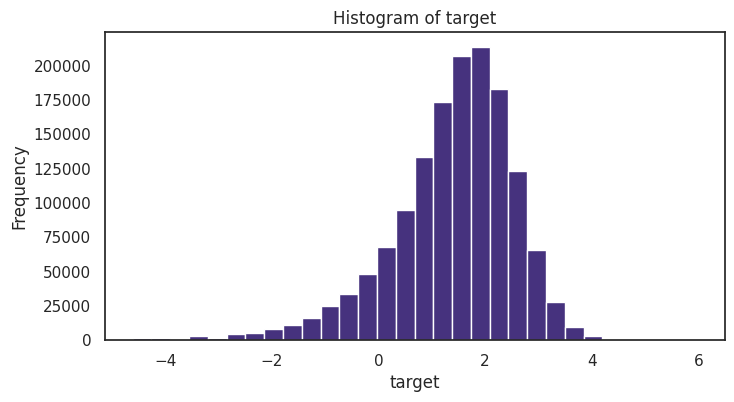

In [14]:
plt.figure(figsize=(8,4))
plt.hist(np.log1p(df['target']), bins=30)
plt.title(f'Histogram of target')
plt.xlabel('target')
plt.ylabel('Frequency')
plt.show()

## Data Preprocessing

### Dropping not important features

In [15]:
df.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
time_id                      int64
row_id                      object
dtype: object

All of the data that we will be using to train the model is already in integer or float form except for the `row_id`, which is unnecessary to make predictions.

In [16]:
df = df.drop(columns=['row_id'])

In [17]:
df.shape

(2618990, 16)

In [18]:
df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id'],
      dtype='object')

### Handling NULL values

In [19]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 103
imbalance_buy_sell_flag          0
reference_price                103
matched_size                   103
far_price                  1446889
near_price                 1428361
bid_price                      103
bid_size                         0
ask_price                      103
ask_size                         0
wap                            103
target                          43
time_id                          0
dtype: int64

Analyzing the nulls in the dataset, we determine that the `far_price` and `near_price` are only released after 3:55.

To seperate the logic for stocks before 3:55 and stocks after, we add a seperate 'boolean' (0 or 1) class called `is_355`.

In [20]:
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,2.618990e+06,2.618990e+06,2.618990e+06,2.618887e+06,2.618990e+06,2.618887e+06,2.618887e+06,1.172101e+06,1.190629e+06,2.618887e+06,2.618990e+06,2.618887e+06,2.618990e+06,2.618887e+06,2.618947e+06,2.618990e+06
mean,9.933103e+01,2.414737e+02,2.699868e+02,5.723558e+06,-1.190115e-02,9.999932e-01,4.514429e+07,1.001478e+00,9.996485e-01,9.997240e-01,5.183046e+04,1.000262e+00,5.348911e+04,9.999898e-01,-4.515214e-02,1.330805e+04
std,5.787595e+01,1.385225e+02,1.587434e+02,2.061102e+07,8.852762e-01,2.529375e-03,1.405603e+08,6.606346e-01,1.217708e-02,2.496408e-03,1.122303e+05,2.506506e-03,1.271071e+05,2.494309e-03,9.448355e+00,7.618751e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,8.706420e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.074503e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.426213e+04,-1.000000e+00,9.987620e-01,5.284785e+06,9.963280e-01,9.970960e-01,9.985290e-01,7.382503e+03,9.990280e-01,7.827525e+03,9.987800e-01,-4.559755e+00,6.731000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.112141e+06,0.000000e+00,9.999660e-01,1.288149e+07,9.998790e-01,9.998850e-01,9.997270e-01,2.197008e+04,1.000207e+00,2.300092e+04,9.999970e-01,-6.020069e-02,1.334600e+04
75%,1.500000e+02,3.610000e+02,4.100000e+02,4.195108e+06,1.000000e+00,1.001173e+00,3.270628e+07,1.003312e+00,1.002587e+00,1.000903e+00,5.585599e+04,1.001413e+00,5.784893e+04,1.001148e+00,4.409552e+00,1.990400e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.961089e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,2.707694e+07,1.077836e+00,5.440500e+07,1.077675e+00,3.877795e+02,2.645400e+04


In [21]:
df['is_355'] = df['seconds_in_bucket'].apply(lambda x: 1 if x >= 300 else 0)
df.loc[df['is_355'] == 0, ['near_price', 'far_price']] = 0

In [22]:
df.isnull().sum()

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size               103
imbalance_buy_sell_flag        0
reference_price              103
matched_size                 103
far_price                  18575
near_price                    47
bid_price                    103
bid_size                       0
ask_price                    103
ask_size                       0
wap                          103
target                        43
time_id                        0
is_355                         0
dtype: int64

Unfortunatly, we still have some nulls in our dataframe. In order to correct further lets use an imputer on each grouping of stocks. We need to ensure that the imputer acts on each stock individually and does not consider data from other stocks when calculating an intermediate value.



In [23]:
def knn_interpolate_group(group):
    imputer = KNNImputer(n_neighbors=2)
    group['far_price'] = imputer.fit_transform(group[['far_price']])

    return group

df = df.groupby('stock_id', group_keys=False).apply(knn_interpolate_group)

In [24]:
df.isnull().sum()

stock_id                     0
date_id                      0
seconds_in_bucket            0
imbalance_size             103
imbalance_buy_sell_flag      0
reference_price            103
matched_size               103
far_price                    0
near_price                  47
bid_price                  103
bid_size                     0
ask_price                  103
ask_size                     0
wap                        103
target                      43
time_id                      0
is_355                       0
dtype: int64

Observing the rest of the null values, using an imputer won't be that efficient because what is left to remove is not a significant amount of data nor a significant timeframe. Therefore we will drop these columns.

In [25]:
df[df.isnull().any(axis=1)]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,is_355
25839,19,438,360,NaN,-1,NaN,NaN,0.449203,NaN,NaN,2977.80,NaN,5166.20,NaN,10.360479,24126,1
65629,158,388,540,NaN,0,NaN,NaN,0.451562,NaN,NaN,0.00,NaN,0.00,NaN,NaN,21394,1
88337,19,438,10,NaN,-1,NaN,NaN,0.000000,0.0,NaN,993.40,NaN,3776.44,NaN,3.800392,24091,0
223093,131,35,250,NaN,0,NaN,NaN,0.000000,0.0,NaN,0.00,NaN,0.00,NaN,NaN,1950,0
273376,131,35,80,NaN,0,NaN,NaN,0.000000,0.0,NaN,0.00,NaN,0.00,NaN,NaN,1933,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469472,101,328,120,NaN,0,NaN,NaN,0.000000,0.0,NaN,147548.61,NaN,3951.90,NaN,-9.779930,18052,0
2493133,101,328,510,NaN,0,NaN,NaN,0.442738,NaN,NaN,142515.78,NaN,78870.00,NaN,-7.159710,18091,1
2550782,101,328,440,NaN,0,NaN,NaN,0.442738,NaN,NaN,84185.46,NaN,6303.52,NaN,-0.810027,18084,1
2616275,101,328,330,NaN,0,NaN,NaN,0.442738,NaN,NaN,78652.00,NaN,86667.90,NaN,-9.869933,18073,1


In [26]:
df = df.dropna()
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,is_355
0,10,457,50,649143.74,1,0.999808,1.311118e+07,0.000000,0.000000,0.999626,45605.28,0.999808,23877.15,0.999746,4.270077,25140,0
1,197,249,70,2480676.30,1,0.998133,7.039544e+06,0.000000,0.000000,0.997941,51840.00,0.998229,46462.08,0.998093,-3.619790,13702,0
2,41,257,280,95485320.75,1,1.001244,3.183543e+08,0.000000,0.000000,1.001466,8858.71,1.001742,4340.16,1.001651,-2.250075,14163,0
3,198,411,420,2487847.57,1,1.001232,1.112020e+08,1.007072,1.003735,1.000954,543017.12,1.001232,212868.00,1.001153,-1.940131,22647,1
4,104,113,30,7020381.95,-1,0.999986,1.959290e+07,0.000000,0.000000,0.999986,5387.00,1.000172,34267.68,1.000011,1.289845,6218,0


In [27]:
df.shape

(2618887, 17)

In [28]:
df.isnull().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
is_355                     0
dtype: int64

## Feature Engineering

### Total Volume

Found by aggregating the size of the ask (sell orders) and bid (buy orders). This figure represents the total quantity of shares offered for sale and purchase, providing insight into the market's liquidity at any given moment.

In [29]:
# total volume --> summing the ask size and bid size
df["volume"] = df["ask_size"] + df["bid_size"]

In [30]:
# difference between ask price and bid price
df["price_spread"] = df["ask_price"] - df["bid_price"]

In [31]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,is_355,volume,price_spread
0,10,457,50,649143.74,1,0.999808,1.311118e+07,0.000000,0.000000,0.999626,45605.28,0.999808,23877.15,0.999746,4.270077,25140,0,69482.43,0.000182
1,197,249,70,2480676.30,1,0.998133,7.039544e+06,0.000000,0.000000,0.997941,51840.00,0.998229,46462.08,0.998093,-3.619790,13702,0,98302.08,0.000288
2,41,257,280,95485320.75,1,1.001244,3.183543e+08,0.000000,0.000000,1.001466,8858.71,1.001742,4340.16,1.001651,-2.250075,14163,0,13198.87,0.000276
3,198,411,420,2487847.57,1,1.001232,1.112020e+08,1.007072,1.003735,1.000954,543017.12,1.001232,212868.00,1.001153,-1.940131,22647,1,755885.12,0.000278
4,104,113,30,7020381.95,-1,0.999986,1.959290e+07,0.000000,0.000000,0.999986,5387.00,1.000172,34267.68,1.000011,1.289845,6218,0,39654.68,0.000186


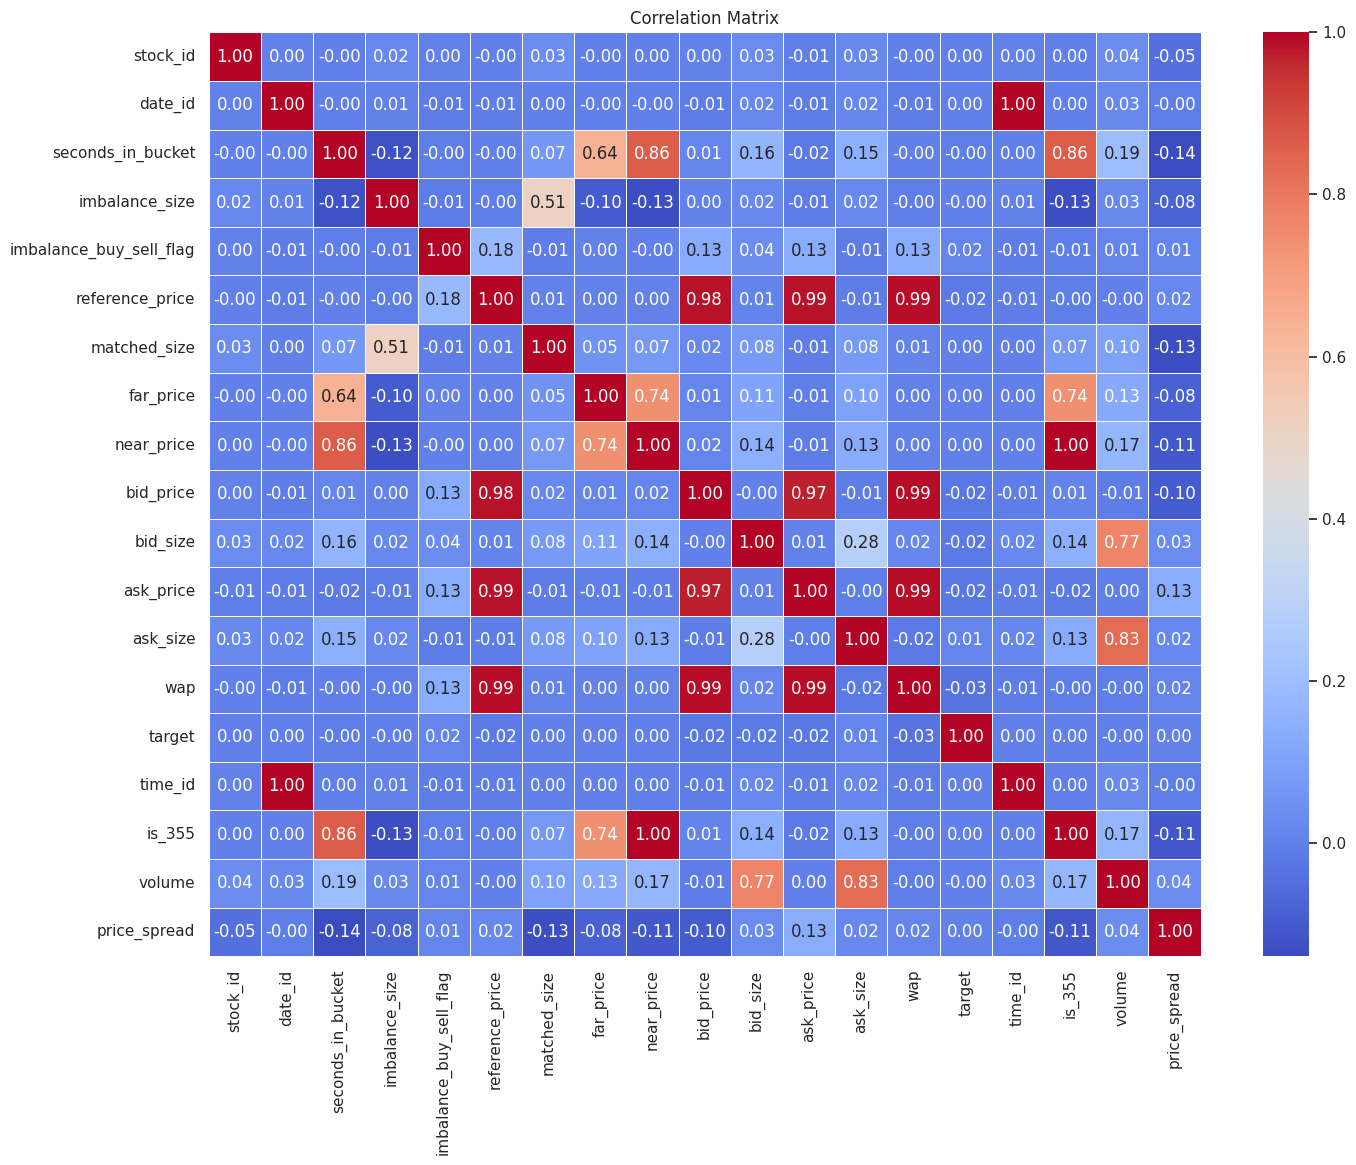

In [32]:
correlation_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)

plt.title('Correlation Matrix')
plt.show()

In [33]:
df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'is_355', 'volume',
       'price_spread'],
      dtype='object')

### Selecting Features

In [34]:
num_vars = ['date_id', 'seconds_in_bucket', 'imbalance_size', 'reference_price',
            'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size',
            'ask_price', 'ask_size', 'wap', 'is_355', 'volume', 'price_spread']

cat_vars = ['stock_id', 'imbalance_buy_sell_flag', 'time_id']

In [35]:
features = df[num_vars]
features.head()

,date_id,seconds_in_bucket,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,is_355,volume,price_spread
0,457,50,649143.74,0.999808,1.311118e+07,0.000000,0.000000,0.999626,45605.28,0.999808,23877.15,0.999746,0,69482.43,0.000182
1,249,70,2480676.30,0.998133,7.039544e+06,0.000000,0.000000,0.997941,51840.00,0.998229,46462.08,0.998093,0,98302.08,0.000288
2,257,280,95485320.75,1.001244,3.183543e+08,0.000000,0.000000,1.001466,8858.71,1.001742,4340.16,1.001651,0,13198.87,0.000276
3,411,420,2487847.57,1.001232,1.112020e+08,1.007072,1.003735,1.000954,543017.12,1.001232,212868.00,1.001153,1,755885.12,0.000278
4,113,30,7020381.95,0.999986,1.959290e+07,0.000000,0.000000,0.999986,5387.00,1.000172,34267.68,1.000011,0,39654.68,0.000186


In [36]:
target = df['target']
target.head()

0    4.270077
1   -3.619790
2   -2.250075
3   -1.940131
4    1.289845
Name: target, dtype: float64

### Normalize features

In [37]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(features)

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
batch_size = 10000  # Adjust based on your dataset size and memory constraints

scaled_features = []

# Normalize in batches
for i in range(0, len(features), batch_size):
    batch_scaled = scaler.fit_transform(features[i:i+batch_size])
    scaled_features.append(batch_scaled)

# Concatenate the batch-wise scaled features into a single array
scaled_features = np.concatenate(scaled_features, axis=0)

### Convert data to sequences

In [39]:
seq_length = 5
X, y = [], []
for i in range(len(scaled_features) - seq_length):
    X.append(scaled_features[i:i + seq_length])
    y.append(target.iloc[i + seq_length])
X, y = np.array(X), np.array(y)

### Splitting the dataset

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2095105, 5, 15), (523777, 5, 15), (2095105,), (523777,))

## Model Selection

In [42]:
N_FEATURES = len(num_vars)  # number of features
N_LAGS = 5                  # sequence length
LEARNING_RATE = 0.001
dropout = 0.2

### Experiment 1

### Basic LSTM

- Single LSTM layer with 25 units.
- Dropout layers.
- Dense output layer.

In [43]:
model = Sequential()
model.add(Input(shape=(N_LAGS, N_FEATURES)))
model.add(Dropout(dropout))
model.add(LSTM(25, return_sequences=False))
model.add(Dropout(dropout))
model.add(Dense(1))

In [45]:
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
)

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 5, 15)             0         
                                                                 
 lstm (LSTM)                 (None, 25)                4100      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 4126 (16.12 KB)
Trainable params: 4126 (16.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


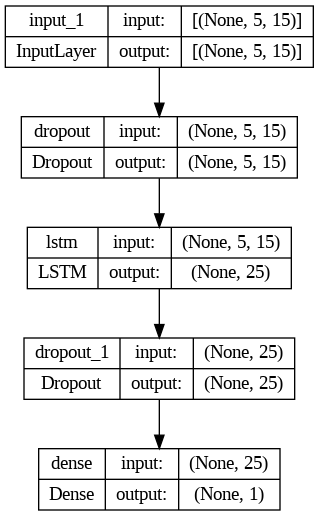

In [51]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Train the model

In [46]:
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
65473/65473 [==============================] - 279s 4ms/step - loss: 89.2037
Epoch 2/5
65473/65473 [==============================] - 270s 4ms/step - loss: 89.2004
Epoch 3/5
65473/65473 [==============================] - 272s 4ms/step - loss: 89.2002
Epoch 4/5
65473/65473 [==============================] - 280s 4ms/step - loss: 89.2001
Epoch 5/5
65473/65473 [==============================] - 279s 4ms/step - loss: 89.2012


### Evaluate the model on the test set


In [47]:
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

16369/16369 [==============================] - 47s 3ms/step - loss: 89.5621
Test Loss: 89.56214141845703


### Experiment 2

### Enhanced LSTM

- Bidirectional LSTM with 50 units.
- Additional Dense layers with ReLU activation and L2 regularization.
- Batch normalization and Dropout layers.

In [52]:
model = Sequential()
model.add(Input(shape=(N_LAGS, N_FEATURES)))
model.add(Dropout(dropout))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(BatchNormalization())
model.add(LSTM(25, return_sequences=False))
model.add(Dropout(dropout))
model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

In [53]:
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
)

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 5, 15)             0         
                                                                 
 bidirectional (Bidirection  (None, 5, 100)            26400     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 5, 100)            400       
 Normalization)                                                  
                                                                 
 lstm_2 (LSTM)               (None, 25)                12600     
                                                                 
 dropout_3 (Dropout)         (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 50)               

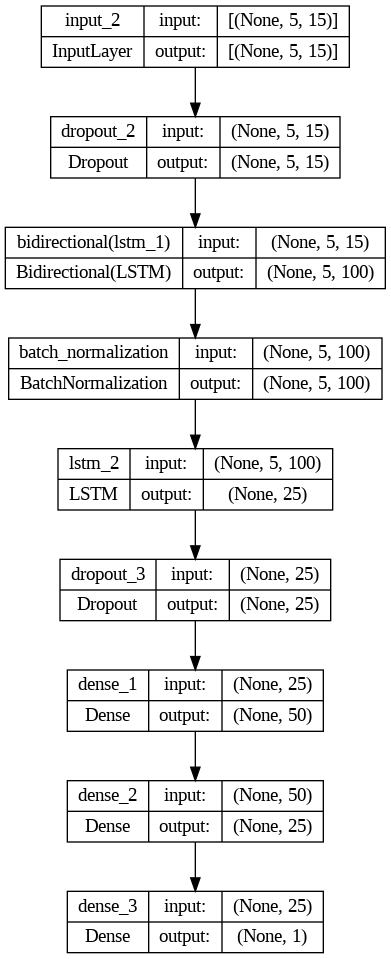

In [55]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [56]:
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
65473/65473 [==============================] - 587s 9ms/step - loss: 89.2094
Epoch 2/5
65473/65473 [==============================] - 562s 9ms/step - loss: 89.2001
Epoch 3/5
65473/65473 [==============================] - 580s 9ms/step - loss: 89.2005
Epoch 4/5
65473/65473 [==============================] - 579s 9ms/step - loss: 89.2002
Epoch 5/5
65473/65473 [==============================] - 564s 9ms/step - loss: 89.2002


In [57]:
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

16369/16369 [==============================] - 60s 4ms/step - loss: 89.5646
Test Loss: 89.56463623046875


### Experiment 3

### CNN-LSTM Hybrid Model

- 1D Convolutional layers for feature extraction.
- LSTM layers for capturing temporal dynamics.
- Dense output layer.

In [72]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [74]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 3, 64)             1216      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 1, 50)             23000     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 44467 (173.70 KB)
Trainable params: 44467 (173.70 KB)
Non-trainable params: 0 (0.00 Byte)
________________

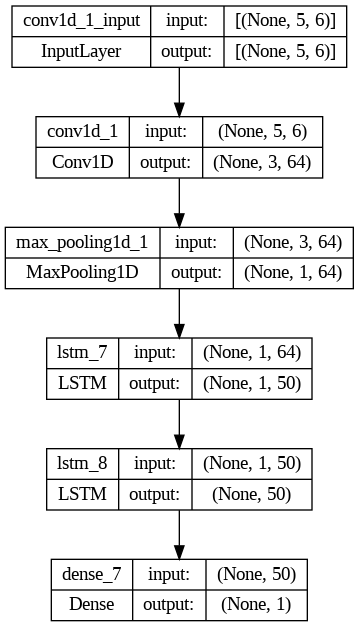

In [75]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [73]:
model.fit(X_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
65473/65473 [==============================] - 387s 6ms/step - loss: 89.2008
Epoch 2/5
65473/65473 [==============================] - 368s 6ms/step - loss: 89.2000
Epoch 3/5
65473/65473 [==============================] - 371s 6ms/step - loss: 89.2010
Epoch 4/5
65473/65473 [==============================] - 368s 6ms/step - loss: 89.2000
Epoch 5/5
65473/65473 [==============================] - 371s 6ms/step - loss: 89.2007


In [76]:
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

16369/16369 [==============================] - 49s 3ms/step - loss: 89.5636
Test Loss: 89.5636215209961


## Conclusion

Model Name | Specifications | Test Loss | Reasoning
--- | --- | --- | ---
Enhanced LSTM | Bidirectional LSTM with 50 units. Additional Dense layers with ReLU activation and L2 regularization. Batch normalization and Dropout layers | 89.5646 | Increased complexity didn't improve performance, possibly due to data noise or insufficient feature engineering.
CNN-LSTM Hybrid Model | 1D Convolutional layers for feature extraction. LSTM layers for capturing temporal dynamics. Dense output layer | 89.5636 | Combines spatial feature extraction of CNNs with temporal dynamics of LSTMs. Performance is similar to other models, suggesting other factors like data features or noise might be limiting accuracy.
Basic LSTM | Single LSTM layer with 25 units.  Dropout layers. Dense output layer | 89.5621 | The model is too simple to capture complex patterns in the stock market data.


### Basic LSTM has the best accuracy among all the experiments.